# Congressional Tweets Classification
## Derek Caramella
## 13 February 2022

# Table of Contents
1. [Modules](#modules)
    1. [Import Modules](#import-modules)
2. [Descriptive Analysis](#descriptive-analysis)
    1. [Text Cleaner](#text-cleaner)
    2. [Descriptive Statistics](#descriptive-statistics)
    3. [Time Series](#time-series)
    4. [Latent Dirichlet Allocation](#LDA)
    5. [Non-Negative Matrix Factorization](#non-negative-matrix-factorization)
3. [Model Creation & Predicition](#model-creation-prediction)
    1. [Preprocessing](#preprocessing)
    2. [Model Creation](#model-creation)
    3. [Prediction](#prediction)
    4. [Evaulation](#evaulation)

# Modules
<a class='anchor' id='modules'></a>

## Import Modules
<a class='anchor' id='import-modules'></a>

In [43]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis.sklearn

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import openpyxl
import warnings
import random
import os

import pickle

import matplotlib.font_manager
warnings.filterwarnings('ignore')  # Filter Errors
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Ensure line graphs display on graphs

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

In [2]:
# Import the raw dataset
training_tweet_df = pd.read_csv(r'congressional_tweet_training_data.csv')
test_tweet_df = pd.read_csv(r'congressional_tweet_test_data.csv')

training_tweet_df['Train'] = 1
test_tweet_df['Train'] = 0

raw_tweet_df = training_tweet_df.append(test_tweet_df)

raw_tweet_df.head(3)

,Id,Train,favorite_count,full_text,hashtags,party,party_id,retweet_count,year
0,NaN,1,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,NaN,R,10,2017.0
1,NaN,1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,NaN,R,111,2020.0
2,NaN,1,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,NaN,R,2,2014.0


In [3]:
# Replace time feature with datetime object
raw_tweet_df['year'] = raw_tweet_df['year'].fillna(value=raw_tweet_df['year'].mean())
raw_tweet_df['year'] = raw_tweet_df['year'].astype('int32').astype('str')
raw_tweet_df['year'] = pd.to_datetime(raw_tweet_df['year'], format='%Y')

raw_tweet_df.head(3)

,Id,Train,favorite_count,full_text,hashtags,party,party_id,retweet_count,year
0,NaN,1,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,NaN,R,10,2017-01-01
1,NaN,1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,NaN,R,111,2020-01-01
2,NaN,1,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,NaN,R,2,2014-01-01


In [4]:
raw_tweet_df['hashtags'] = raw_tweet_df['hashtags'].apply(lambda x: x.split())

raw_tweet_df.head(3)

,Id,Train,favorite_count,full_text,hashtags,party,party_id,retweet_count,year
0,NaN,1,0,"b""RT @KUSINews: One of our longtime viewers wa...",[KUSI],NaN,R,10,2017-01-01
1,NaN,1,258,"b""Today I'm urging the @CDCgov to immediately ...",[Coronavirus],NaN,R,111,2020-01-01
2,NaN,1,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",[MO03],NaN,R,2,2014-01-01


## Text Cleaner
<a class='anchor' id='text-cleaner'></a>

In [6]:
def text_cleaner(text):
    """
    Removes stopwords, words shorter than 3 characters, all links (href), emojis, & punctuation.
    :type text: string
    """
    additional_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 
                                'we', 'our', 'ours', 'ourselves', 'you', 
                                "you're", "you've", "you'll", "you'd", 'your', 
                                'yours', 'yourself', 'yourselves', 'he', 'him', 
                                'his', 'himself', 'she', "she's", 'her', 'hers',
                                'herself', 'it', "it's", 'its', 'itself', 'they',
                                'them', 'their', 'theirs', 'themselves', 'what',
                                'which', 'who', 'whom', 'this', 'that', "that'll",
                                'these', 'those', 'am', 'is', 'are', 'was', 'were',
                                'be', 'been', 'being', 'have', 'has', 'had', 'having',
                                'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
                                'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                                'at', 'by', 'for', 'with', 'about', 'against', 'between',
                                'into', 'through', 'during', 'before', 'after', 'above', 
                                'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                                'over', 'under', 'again', 'further', 'then', 'once', 'here',
                                'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
                                'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only',
                                'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
                                'will', 'just', 'don', "don't", 'should', "should've", 'now',
                                'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 
                                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
                                'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
                                "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                                'won', "won't", 'wouldn', "wouldn't"])
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    text = text[2:-1]  # Remove the leading b, it looks like it's encoded but it's not
    text = text.replace('&amp;', 'and')
    text = text.replace(r"\'s", r"'s'")
    text = ' '.join(filter(lambda x:x[0]!=r'//', text.split()))
    text = ' '.join(re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',' ', text).split())  # Remove hashtags #Derek, would be '' & https: links
    
    text = re.sub(emoji_pattern, '', text)  # Remove all emoji patterns
    text = re.sub("<a.+?>", ' ', text)  # Remove url, but keep the label
    
    html_tag_cleaner = re.compile('<.*?>')  # Remove any html div
    text = re.sub(html_tag_cleaner, '', text)  # Execute html removal
    
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)  # Remove all special characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)  # Remove all words less than or equal to 3 characters
    text = text.lower()  # Lower case text
    text = remove_stopwords(text)  # Removes stop words
    # Remove contractions or other custom stopwords
    text = ' '.join(e.lower() for e in text.split() if e.lower() not in additional_stopwords)
    
    text = re.sub(r"won't", "will not", text)  # Replace these words
    text = re.sub(r"can\'t", "can not", text)  # Replace these words
    text = re.sub(r"n\'t", " not", text)  # Replace these words
    text = re.sub(r"\'re", " are", text)  # Replace these words
    text = re.sub(r"\'s", " is", text)  # Replace these words
    text = re.sub(r"\'d", " would", text)  # Replace these words
    text = re.sub(r"\'ll", " will", text)  # Replace these words
    text = re.sub(r"\'t", " not", text)  # Replace these words
    text = re.sub(r"\'ve", " have", text)  # Replace these words
    text = re.sub(r"\'m", " am", text)  # Replace these words
    
    text = re.sub(' +', ' ', text)  # Remove double whitespace
    text = text.strip()  # Remove leading & trailing whitespace
    return text

In [7]:
# Tags the words in the text
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(nltk.corpus.wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(nltk.corpus.wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(nltk.corpus.wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(nltk.corpus.wordnet.ADV)
    else:
        return(None)

In [8]:
lemmatizer = WordNetLemmatizer()


# Lemmatizes the words in texts and returns the cleaned and lemmatized text
def lemmatize_text(text):
    # Tokenize the text and find the POS tag for each token
    text = text_cleaner(text)
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None: # If there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:  # Else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return(' '.join(lemmatized_text))

In [9]:
raw_tweet_df['full_text_clean'] = raw_tweet_df['full_text'].apply(lambda x: lemmatize_text(x))  # Lemmatize global df

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

In [10]:
raw_tweet_df['full_text_clean_length'] = raw_tweet_df['full_text_clean'].str.len()  # Number of characters in summary

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


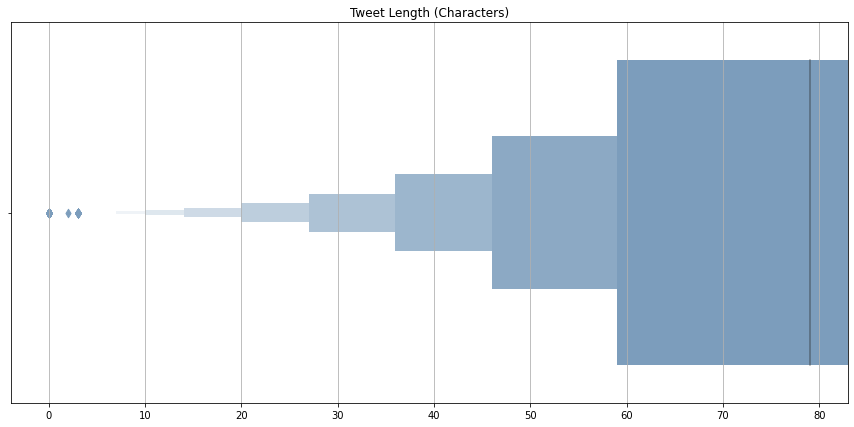

In [11]:
fig, ax = plt.subplots(constrained_layout=False, figsize=(15, 7))  # A figure with size attributes

"""
Boxenplots:
It is similar to a box plot in plotting a nonparametric representation of a
distribution in which all features correspond to actual observations. By plotting more quantiles, 
it provides more information about the shape of the distribution, particularly in the tails.
"""

# First plot, the number of characters in a summary distribution
sns.boxenplot(data=raw_tweet_df[raw_tweet_df['full_text_clean_length'] < raw_tweet_df['full_text_clean_length'].quantile(0.95)],
              x='full_text_clean_length', 
              color='#719ec7',
              ax=ax).set(xlabel=None)
ax.set_title('Tweet Length (Characters)')  # Set title

plt.show()

## Time Series
<a class='anchor' id='time-series'></a>

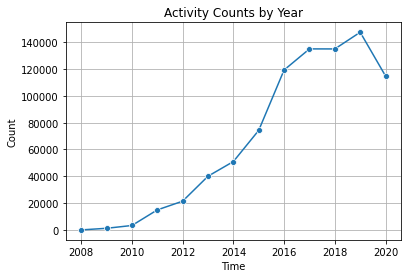

In [12]:
time_series_tweet_count = raw_tweet_df.copy()  # Copy the raw text file

# Only take Year and text. We need text column to count by
time_series_tweet_count = time_series_tweet_count[['year', 'full_text']]

# Group by Year to acquire count of texts
time_series_tweet_count = time_series_tweet_count.groupby(by=['year'], as_index=False).count()

fig, ax = plt.subplots(figsize=(6,4))  # A figure with size attributes
ax = sns.lineplot(data=time_series_tweet_count, 
                  x='year', 
                  y='full_text', 
                  marker='o')

ax.set_xlabel('Time')  # Set x title
ax.set_ylabel('Count')  # Set y title
ax.set_title('Activity Counts by Year')  # Set main title

plt.show()  # Show graph

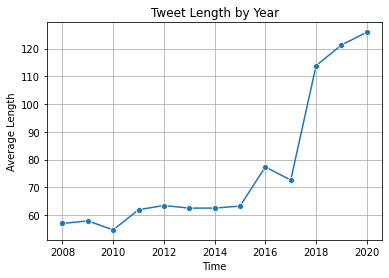

In [13]:
time_series_tweet_count = raw_tweet_df.copy()  # Copy the raw text file

# Only take Year and text. We need text column to count by
time_series_tweet_count = time_series_tweet_count[['year', 'full_text_clean_length']]

# Group by Year to acquire count of texts
time_series_tweet_count = time_series_tweet_count.groupby(by=['year'], as_index=False).mean()

fig, ax = plt.subplots(figsize=(6,4))  # A figure with size attributes
ax = sns.lineplot(data=time_series_tweet_count, 
                  x='year', 
                  y='full_text_clean_length', 
                  marker='o')

ax.set_xlabel('Time')  # Set x title
ax.set_ylabel('Average Length')  # Set y title
ax.set_title('Tweet Length by Year')  # Set main title

plt.show()  # Show graph

## Latent Dirichlet Allocation
<a class='anchor' id='LDA'></a>

In [14]:
text = ' '.join(review for review in raw_tweet_df['full_text_clean'])  # Acquire all cleaned text in one long string
cloud_mask = np.array(Image.open('img/president.jpg'))  # Load in custom image as the word cloud mask

In [ ]:
# Initialize Word Cloud with image mask
wc = WordCloud(background_color='white', max_words=500, mask=cloud_mask, contour_width=0.2, contour_color='k', colormap='seismic')
wc.generate(text)  # Populate the word cloud

plt.figure(figsize=(20, 10))  # Initialize plot
plt.imshow(wc, interpolation='bilinear')  # Show plot
plt.axis('off')  # Turn off axis for good apperance
plt.show()  # Show

In [16]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
    A function for LDA & NMF to plot the top ten words in each topic.
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 15), sharex=True) # Initialize plot with subplots 1 row with 5 columns
    axes = axes.flatten()  # Flatten the axis
    for topic_idx, topic in enumerate(model.components_):  # For each topic id and topic in the model components
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]  # Sort the topics
        top_features = [feature_names[i] for i in top_features_ind]  # Sort the features
        weights = topic[top_features_ind]  # Acquire the weights

        ax = axes[topic_idx]  # Set the axes according to the topic id, so 1 is first and 5 is last
        ax.barh(top_features, weights, height=0.7)  # Set the bar height
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})  # Set the header depending on topic
        ax.invert_yaxis()  # Invert the y-axis so top word is first
        ax.tick_params(axis="both", which="major", labelsize=20)  # Set tick parameters
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  # Set title
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)  # Organize spacing for prettiness
    plt.show()

In [17]:
n_features = 1000  # 1,000 features
n_components = 5  # 5 components (topics)
n_top_words = 20  # 20 number top words

In [18]:
# Count vector for LDA
tf_vectorizer = CountVectorizer(max_df=0.95,  # maximum 95% apperance
                                min_df=2,  # Minimum greater than 2 appearances
                                max_features=n_features,  # 1,000 features
                                stop_words='english')  # English stop words

In [19]:
tf = tf_vectorizer.fit_transform(raw_tweet_df['full_text_clean'])  # Fit CountVector with clean text, then transform

In [20]:
# Take our CountVectorizer and train LDA object
lda = LatentDirichletAllocation(  # LDA object
    n_components=n_components,  # 5 topics
    max_iter=10,  # 10 maximum iterations
    learning_method='online',
    learning_offset=50.0,
    random_state=0)  # seed

In [21]:
lda.fit(tf)  # Fit our model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


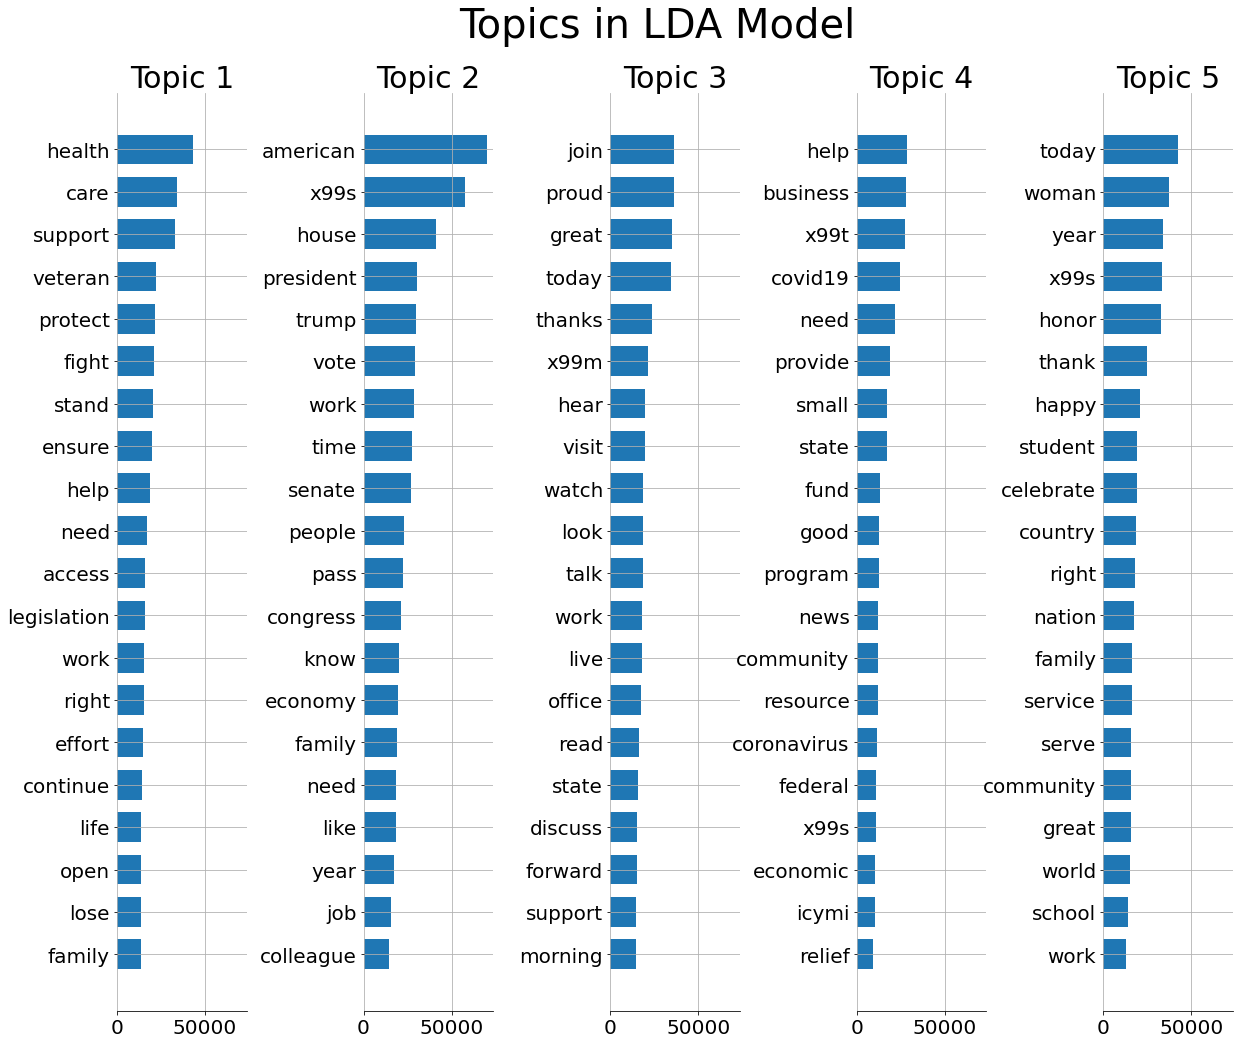

In [22]:
tf_feature_names = tf_vectorizer.get_feature_names()  # Acquire feature names
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA Model')  # plot

In [23]:
pyLDAvis.enable_notebook()  # Enable workbook for interaction
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')  # Cool interaction of topics
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -382.468109 -376.120270       1        1  25.504053
0       -7.897199  157.415848       2        1  20.354731
2     -357.594238   14.876245       3        1  18.851185
4      282.154114 -106.002159       4        1  18.715122
3       -4.376029 -353.611328       5        1  16.574910, topic_info=     Category          Freq         Term          Total  loglift  logprob
term                                                                     
47    Default  68450.000000     american   68450.000000  30.0000  30.0000
396   Default  43448.000000       health   43448.000000  29.0000  29.0000
978   Default  37534.000000        woman   37534.000000  28.0000  28.0000
700   Default  35996.000000        proud   35996.000000  27.0000  27.0000
420   Default  40152.000000        house   40152.000000  26.0000  26.0000
114   Default  34278.000000         care   34278.000000  25.0000  25.0000
414   Default  32501.000000        honor   32501.000000  24.0000  24.0000
381   Default  50791.000000        great   50791.000000  23.0000  23.0000
472   Default  42676.000000         join   42676.000000  22.0000  22.0000
109   Default  28787.000000     business   28787.000000  21.0000  21.0000
996   Default  50629.000000         year   50629.000000  20.0000  20.0000
993   Default  28053.000000         x99t   28053.000000  19.0000  19.0000
862   Default  48046.000000      support   48046.000000  18.0000  18.0000
202   Default  25160.000000      covid19   25160.000000  17.0000  17.0000
403   Default  58871.000000         help   58871.000000  16.0000  16.0000
675   Default  29385.000000    president   29385.000000  15.0000  15.0000
913   Default  29195.000000        trump   29195.000000  14.0000  14.0000
886   Default  23478.000000       thanks   23478.000000  13.0000  13.0000
884   Default  34079.000000        thank   34079.000000  12.0000  12.0000
794   Default  26488.000000       senate   26488.000000  11.0000  11.0000
990   Default  21398.000000         x99m   21398.000000  10.0000  10.0000
701   Default  19803.000000      provide   19803.000000   9.0000   9.0000
936   Default  22256.000000      veteran   22256.000000   8.0000   8.0000
390   Default  20919.000000        happy   20919.000000   7.0000   7.0000
837   Default  33132.000000        state   33132.000000   6.0000   6.0000
581   Default  58125.000000         need   58125.000000   5.0000   5.0000
834   Default  20725.000000        stand   20725.000000   4.0000   4.0000
399   Default  19761.000000         hear   19761.000000   3.0000   3.0000
945   Default  19595.000000        visit   19595.000000   2.0000   2.0000
813   Default  17845.000000        small   17845.000000   1.0000   1.0000
...       ...           ...          ...            ...      ...      ...
174    Topic5   8357.432586     congrats    8358.240854   1.7972  -4.9069
92     Topic5   8159.676932      billion    8160.483417   1.7972  -4.9308
589    Topic5   8177.048921        night    8177.863231   1.7972  -4.9287
664    Topic5   7833.837404        power    7834.652071   1.7972  -4.9716
346    Topic5   7692.588681       follow    7693.399514   1.7972  -4.9898
347    Topic5   7573.776785         food    7574.583773   1.7972  -5.0053
513    Topic5   7288.304361       listen    7289.118394   1.7972  -5.0438
882    Topic5   6908.220743         test    6909.024518   1.7972  -5.0973
759    Topic5   6695.924251     response    6696.730100   1.7972  -5.1285
448    Topic5   6540.660319  information    6541.465010   1.7972  -5.1520
321    Topic5   6572.444235         fair    6573.258744   1.7972  -5.1471
68     Topic5   6427.148789   assistance    6427.952151   1.7972  -5.1695
401    Topic5   6320.414479      hearing    6321.228445   1.7972  -5.1862
879    Topic5   6311.188524         tell    6312.001761   1.7972  -5.1877
379    Topic5   6209.441497        grant    6210.248549   1.7972  -5.2040

## Non-Negative Matrix Factorization
<a class='anchor' id='non-negative-matrix-factorization'></a>

In [24]:
#TfidfVectorizer for NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,  # maximum 95% apperance
                                   min_df=2,  # Minimum greater than 2 appearances
                                   max_features=n_features,  # 1,000 features
                                   stop_words='english')  # English stop words

In [25]:
tfidf = tfidf_vectorizer.fit_transform(raw_tweet_df['full_text_clean'])  # Fit TfidfVectorizer with clean text, then transform

In [26]:
# Take our TfidfVectorizer and train NMF object
nmf = NMF(n_components=n_components,  # 5 topics
          random_state=1,  # seed
          beta_loss='frobenius',  # Specify beta loss
          solver='mu',  # Mu solver
          max_iter=1000,  # Number of iterations
          alpha=0.1,  # Good learning rate
          l1_ratio=0.5)  # L1 ratio for correctness

In [27]:
nmf.fit(tfidf)  # Fit our NMF object

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=1000,
  n_components=5, random_state=1, shuffle=False, solver='mu', tol=0.0001,
  verbose=0)

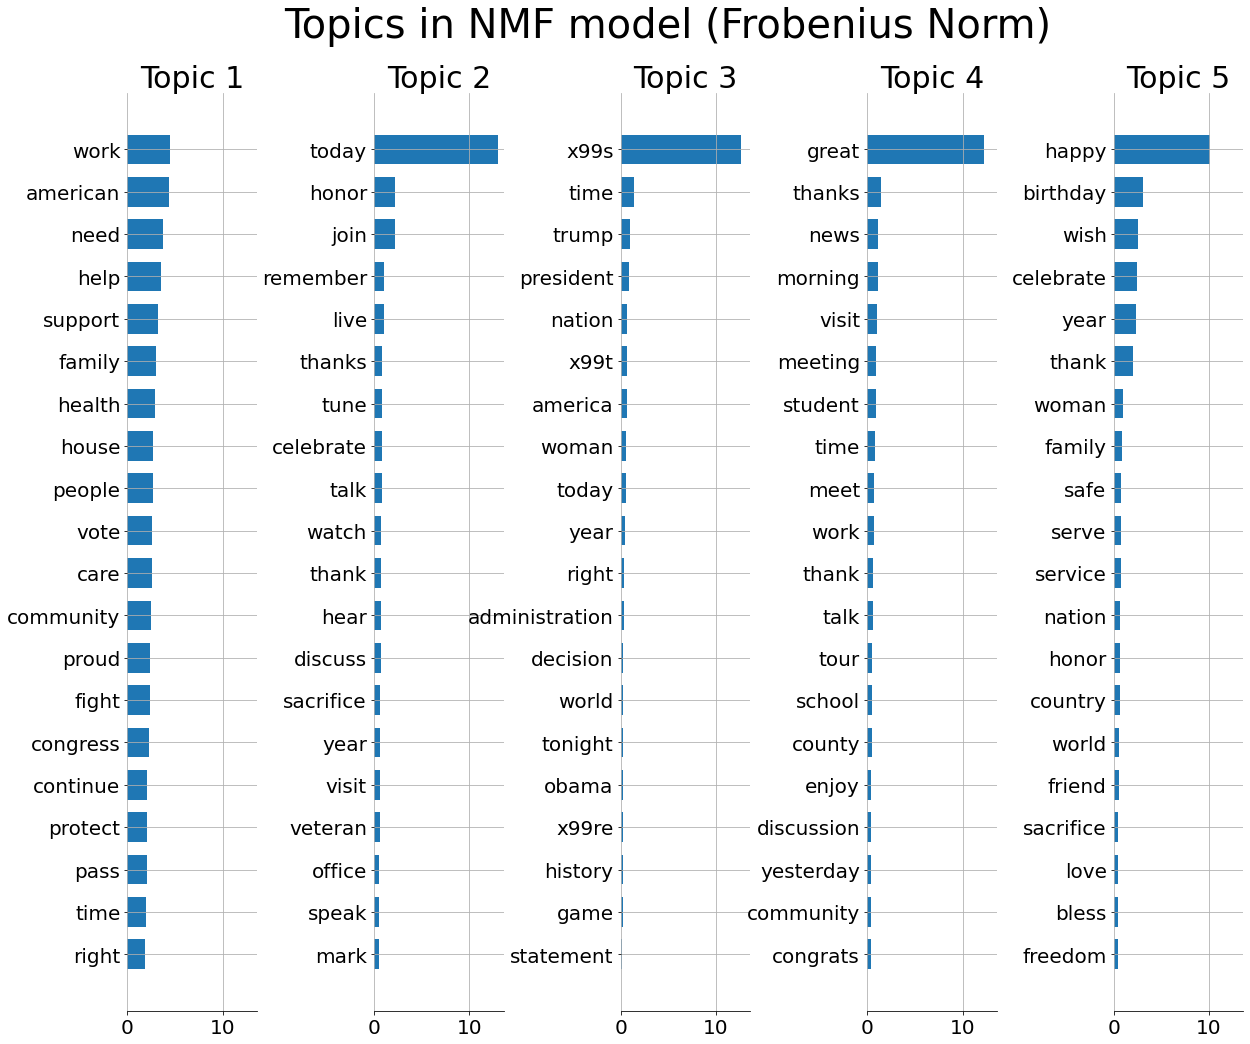

In [28]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()  # Acquire feature names
plot_top_words(nmf, tfidf_feature_names, n_top_words, 'Topics in NMF model (Frobenius Norm)')  # Plot

# Model Creation & Predicition
<a class='anchor' id='model-creation-prediction'></a>

## Model Creation
<a class='anchor' id='model-creation'></a>

In [29]:
# Import the raw dataset
training_tweet_df = pd.read_csv(r'congressional_tweet_training_data.csv')
test_tweet_df = pd.read_csv(r'congressional_tweet_test_data.csv')

In [30]:
int_to_party_dict = {
    0: 'D',
    1: 'R'
}

party_to_int_dict = {
    'D': 0,
    'R': 1
}

In [31]:
X_train = training_tweet_df['full_text']
y_train = training_tweet_df['party_id'].map(party_to_int_dict)
y_train = y_train.values

X_test = test_tweet_df['full_text']
y_test = test_tweet_df['party'].map(party_to_int_dict)
y_test = y_test.values

In [32]:
# with open('train.pickle', 'wb') as f:
#     pickle.dump(train, f)

# with open('test.pickle', 'wb') as f:
#     pickle.dump([X_test, y_test], f)

# with open('train.pickle', 'rb') as f:
#     train = pickle.load(f)
# with open('test.pickle', 'rb') as f:
#     X_test, y_test = pickle.load(f)

In [33]:
X_train['full_text_clean'] = X_train.apply(lambda x: lemmatize_text(x))

In [34]:
sid_obj = SentimentIntensityAnalyzer()

X_train['Scores'] = X_train['full_text_clean'].apply(lambda x: sid_obj.polarity_scores(x))

sentiment = np.concatenate(
    (
        X_train['Scores'].str['neg'].values.reshape(-1, 1),
        X_train['Scores'].str['neu'].values.reshape(-1, 1),
        X_train['Scores'].str['pos'].values.reshape(-1, 1), 
        X_train['Scores'].str['compound'].values.reshape(-1, 1)
    )
    , axis=1)

In [35]:
# TfidfVectorizer for our x features. Fit on the train clean SummaryText. Keep object for the predict pipeline
tfidf_obj = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30500).fit(X_train['full_text_clean'])

# Transfprm clean Summary Text into the independant variables
X_train = tfidf_obj.transform(X_train['full_text_clean'])
X_train = X_train.toarray()  # Convert sparse array to array

In [36]:
X_train = np.concatenate((X_train, sentiment), axis=1)

In [37]:
def predict_review_score(test_x_dataframe, trained_tfidf_object, trained_model):
    """
    Pipeline for preprocessing and prediciton.
    """
#     Clean the Summary Text column
    test_x_dataframe['full_text_clean'] = test_x_dataframe.apply(lambda x: lemmatize_text(x))
    test_x_dataframe['Scores'] = test_x_dataframe['full_text_clean'].apply(lambda x: sid_obj.polarity_scores(x))
    sentiment = np.concatenate(
        (
            test_x_dataframe['Scores'].str['neg'].values.reshape(-1, 1),
            test_x_dataframe['Scores'].str['neu'].values.reshape(-1, 1),
            test_x_dataframe['Scores'].str['pos'].values.reshape(-1, 1), 
            test_x_dataframe['Scores'].str['compound'].values.reshape(-1, 1)
        )
        , axis=1)
#     Transform the clean Summary and Text column using the train trained_tfidf_object
    X = tfidf_obj.transform(test_x_dataframe['full_text_clean'])
    X = X.toarray()  # From sparse matrix to array
    X = np.concatenate((X, sentiment), axis=1)
    predictions = trained_model.predict(X)  # Predict

    return predictions

In [38]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

predictions = predict_review_score(X_test, tfidf_obj, clf)
accuracy_score(y_true=y_test, y_pred=predictions)

0.5487886792452831

In [ ]:
clf = SVC(random_state=0).fit(X_train, y_train)
predictions = predict_review_score(X_test, tfidf_obj, clf)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
predictions = predict_review_score(X_test, tfidf_obj, clf)
accuracy_score(y_true=y_test, y_pred=predictions)

## Prediction
<a class='anchor' id='prediction'></a>

In [ ]:
submission = test_tweet_df.copy()
submission['party'] = predictions
submission['party'] = submission['party'].map(int_to_party_dict)

In [ ]:
submission[['Id', 'party']].to_csv('output.csv', index=False)  # Export these features without the index

## Evaulation
<a class='anchor' id='evaulation'></a>

              precision    recall  f1-score   support

           0       1.00      0.55      0.71    265000
           1       0.00      0.00      0.00         0

   micro avg       0.55      0.55      0.55    265000
   macro avg       0.50      0.27      0.35    265000
weighted avg       1.00      0.55      0.71    265000



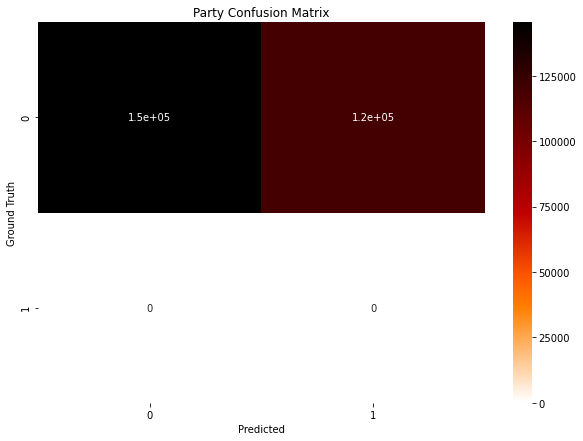

In [41]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)  # Calculate the confusion matrix

plt.figure(figsize = (10,7))  # Initialize plot figure
ax = sns.heatmap(conf_matrix, # Heat map the confusion matrix
                 annot=True,   # Plot the counts on each block
                 cmap='gist_heat_r',  # Reverse the heat map so it is more bright
                )

ax.set(xlabel='Predicted', ylabel='Ground Truth', title='Party Confusion Matrix')
print(classification_report(y_true=y_test, y_pred=predictions))  # Print the classification report
plt.show()  # Show the image